In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
from collections import Counter
from tqdm import tqdm
from sklearn import svm
from numba import njit

In [153]:
csv_path = 'E:/dataset/mdp_classify-master/MDP/MW1.csv'
csv_data = pd.read_csv(csv_path)
total_data, total_label = csv_data.iloc[:, :-1], csv_data.iloc[:, -1]
total_label = [{'N':0, 'Y':1}[i] for i in total_label]
train_data, test_data, train_label, test_label = train_test_split(total_data, total_label, test_size=0.2)

In [154]:
clf = svm.SVC(C=2, kernel='rbf', gamma=5, decision_function_shape='ovr')
clf.fit(train_data, train_label)
clf.score(test_data, test_label)

0.9135802469135802

In [148]:
from sklearn.metrics import confusion_matrix, accuracy_score
def update_eta(train_data, train_label, test_data, test_label, tabu):
    """更新启发式信息, eta = TPR / d
    Returns:
        eta: 从tabu最后一个节点出发到其余节点的启发式信息
    """
    n_dims = train_data.shape[1]
    eta = np.zeros(n_dims)
    flist = list(set(range(n_dims)) - set(tabu)) 

    for i in flist:
        clf = svm.SVC(C=2, kernel='rbf', gamma=5, decision_function_shape='ovr')
        clf.fit(train_data.iloc[:, tabu+[i]], train_label)
        pred = clf.predict(test_data.iloc[:, tabu+[i]])
        cf_matrix = confusion_matrix(test_label, pred)
        FN, TP = cf_matrix[1][0], cf_matrix[1][1]
        eta[i] = TP / (TP + FN) / (len(tabu)+1)

    return eta


In [6]:
def select_route(prob):
    """按路径转移概率选择下一个特征
    """
    cs = np.cumsum(prob)
    p = np.random.rand()
    for i in range(len(cs)):
        if cs[i] > p:
            break
    
    return i


In [7]:
def fitness_func(train_data, train_label, test_data, test_label, selected, omega=0.7):
    """适应度函数，评估特征子集好坏
    Returns:
        result: 适应度
    """
    clf = svm.SVC(C=2, kernel='rbf', gamma=5, decision_function_shape='ovr')
    clf.fit(train_data.iloc[:, selected], train_label)
    pred = clf.predict(test_data.iloc[:, selected])

    cf_matrix = confusion_matrix(test_label, pred)
    TN, FP = cf_matrix[0][0], cf_matrix[0][1]
    FPR = FP / (TN + FP)
    f_result = omega*FPR + (1-omega)*(len(selected)/train_data.shape[1])
    acc = accuracy_score(test_label, pred)
    return f_result, acc


In [8]:
def fitness_func(train_data, train_label, test_data, test_label, selected, omega=0.8):
    """适应度函数，评估特征子集好坏
    Returns:
        result: 适应度
    """
    clf = svm.SVC(C=2, kernel='rbf', gamma=5, decision_function_shape='ovr')
    clf.fit(train_data.iloc[:, selected], train_label)
    pred = clf.predict(test_data.iloc[:, selected])

    cf_matrix = confusion_matrix(test_label, pred)
    TN, FP = cf_matrix[0][0], cf_matrix[0][1]
    FPR = FP / (TN + FP)

    acc = accuracy_score(test_label, pred)
    f_result = omega*(1-acc) + (1-omega)*np.exp(len(selected)/train_data.shape[1]-2)
    # print(FPR, (1-omega)*np.exp(len(selected)/train_data.shape[1]-10), f_result)
    return f_result, acc

In [9]:
def init_eta(train_data, train_label, test_data, test_label):
    n_dims = train_data.shape[1]
    eta = np.zeros([n_dims, n_dims])
    for i in tqdm(range(n_dims)):
        for j in range(n_dims):
            clf = svm.SVC(C=2, kernel='rbf', gamma=5, decision_function_shape='ovr')
            clf.fit(train_data.iloc[:, [i,j]], train_label)
            pred = clf.predict(test_data.iloc[:, [i,j]])
            cf_matrix = confusion_matrix(test_label, pred)
            FN, TP = cf_matrix[1][0], cf_matrix[1][1]
            eta[i][j] = TP / (TP + FN) / 2
    
    return eta

In [238]:
n_epochs = 100
n_dims = train_data.shape[1]
n_ants = 5
print("the Num of the total features:", n_dims)

alpha = 1
beta = 0.2
omega = 0.8
rho = 0.3
mu = 0.7
gamma = 0.7

tau = np.ones([n_dims, n_dims]) # tau 即信息素矩阵
eta = init_eta(train_data, train_label, test_data, test_label) # eta 即启发式信息
print("init finishing")
feat_list = list(range(n_dims)) # feature 总list
best_score = np.inf
score_list = []
acc_list = []

# p_matrix = np.zeros((n_epochs, n_dims, n_dims))
path_matrix = np.zeros((n_epochs, n_ants, n_dims))
nf_matrix = np.zeros((n_epochs, n_ants))
tau_matrix = np.zeros((n_epochs, n_dims, n_dims))
best_matrix = np.zeros((n_epochs,))

for epoch in range(n_epochs):

    # ============ apply once fs ============
    ant_path = np.zeros([n_ants, n_dims])           # 初始化每只蚂蚁在当前迭代中的路径
    ant_acc = np.zeros(n_ants)
    ant_score = np.zeros(n_ants)
    n_feats = np.random.randint(1, n_dims, size=n_ants) # 初始化每只蚂蚁需要选择的特征数
    # n_feats = 8 * np.ones([n_ants], dtype=np.int64)

    for i in range(n_ants):

        ant_path[i, 0] = np.random.randint(n_dims)  # 为每只蚂蚁选择起始节点（特征）
        # ant_path[i, 0] = i
        visited = []                                # 已选择的 feature list
        
        for d in range(n_feats[i]-1):               # 共选择 n_feats-1 次特征
            visited.append(ant_path[i, d])          # 更新 selected 表
            # eta = update_eta(train_data, train_label, test_data, test_label, visited)
                                                    # 更新启发式信息, eta = TPR / d, array(n_dims,)
            p = (tau[int(visited[-1])] ** alpha) * (eta[int(visited[-1])] ** beta)
            p[[int(i) for i in visited]] = 0
            prob = p / sum(p)                       # 计算路径转移矩阵
            route = select_route(prob)              # 寻找下一个特征
            ant_path[i, d+1] = route

    path_matrix[epoch] = ant_path.copy()
    nf_matrix[epoch] = n_feats.copy()

    # ==== evaluate each selected subset ====
    for j in range(n_ants):
        selected = list(ant_path[j, :n_feats[j]])
        f, acc = fitness_func(train_data, train_label, test_data, test_label, selected, omega)
                                                    # 计算适应度函数
        ant_score[j] = f
        ant_acc[j] = acc
        if f <= best_score:                          # 保存为全局的最优解
            best_path = ant_path[j]
            best_score = f
            best_path_acc = acc
    
    best_ant = np.argmin(ant_score)                 # 最优蚂蚁
    best_matrix[epoch] = best_ant
    near_ant = np.argmin(np.concatenate([ant_score[:best_ant], [0], ant_score[best_ant+1:]]))
                                                    # 第二优蚂蚁
    print("Epoch {} Best Score: {}, the Accuracy: {}, Num of Features: {}".format(\
        epoch, ant_score[best_ant], ant_acc[best_ant], n_feats[best_ant]))
    
    score_list.append(ant_score[best_ant])
    acc_list.append(ant_acc[best_ant])

    # ======== update the eta matrix ========
    
    # stage 1 updating
    deta_tau_k = np.zeros([n_ants, n_dims, n_dims])
    for k in range(n_ants):
        value = mu * ant_acc[k] + (1-mu) / n_feats[k] # 更新值
        for m in range(n_feats[k]-1):
            a, b = int(ant_path[k, m]), int(ant_path[k, m+1])
            deta_tau_k[int(k), a, b] = value

    deta_tau_1 = np.sum(deta_tau_k, 0)

    # stage 2 updating
    deta_tau_2 = np.zeros([n_dims, n_dims])
    for p in range(n_feats[best_ant]-1):
        a, b = int(ant_path[best_ant, p]), int(ant_path[best_ant, p+1])
        deta_tau_2[a, b] = gamma * deta_tau_1[a, b]
        
    for p in range(n_feats[near_ant]-1):
        a, b = int(ant_path[near_ant, p]), int(ant_path[near_ant, p+1])
        deta_tau_2[a, b] += (1-gamma) * deta_tau_1[a, b]
    
    # update
    tau = (1-rho) * tau + rho * deta_tau_1 + deta_tau_2
    tau_matrix[epoch] = tau.copy()

print("The Best Ant Path: ", best_path)
print("The Best Score: ", best_score)
print("The Accuracy use Best Path: ", best_path_acc)



  3%|▎         | 1/37 [00:00<00:05,  6.02it/s]

the Num of the total features: 37


100%|██████████| 37/37 [00:07<00:00,  5.17it/s]
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


init finishing
Epoch 0 Best Score: 0.11084617330486843, the Accuracy: 0.9135802469135802, Num of Features: 16
Epoch 1 Best Score: 0.1126125982106765, the Accuracy: 0.9012345679012346, Num of Features: 8
Epoch 2 Best Score: 0.11084617330486843, the Accuracy: 0.9135802469135802, Num of Features: 16
Epoch 3 Best Score: 0.11103729377298271, the Accuracy: 0.9259259259259259, Num of Features: 24
Epoch 4 Best Score: 0.08861236762861623, the Accuracy: 0.9259259259259259, Num of Features: 3
Epoch 5 Best Score: 0.08782966508068978, the Accuracy: 0.9259259259259259, Num of Features: 2
Epoch 6 Best Score: 0.07953996954897877, the Accuracy: 0.9382716049382716, Num of Features: 4
Epoch 7 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14
Epoch 8 Best Score: 0.06966342633910219, the Accuracy: 0.9506172839506173, Num of Features: 4
Epoch 9 Best Score: 0.08208701565720053, the Accuracy: 0.9382716049382716, Num of Features: 7
Epoch 10 Best Score: 0.09985742033794388, 

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_l

Epoch 11 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 12 Best Score: 0.09848891083849282, the Accuracy: 0.9135802469135802, Num of Features: 3
Epoch 13 Best Score: 0.08941651275885527, the Accuracy: 0.9259259259259259, Num of Features: 4
Epoch 14 Best Score: 0.10865141093643887, the Accuracy: 0.9135802469135802, Num of Features: 14
Epoch 15 Best Score: 0.09772118145112474, the Accuracy: 0.9259259259259259, Num of Features: 13
Epoch 16 Best Score: 0.059786883129225685, the Accuracy: 0.9629629629629629, Num of Features: 4
Epoch 17 Best Score: 0.10836545404836931, the Accuracy: 0.9012345679012346, Num of Features: 3

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide



Epoch 18 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 19 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 20 Best Score: 0.10365655306554147, the Accuracy: 0.9135802469135802, Num of Features: 9
Epoch 21 Best Score: 0.0937800098556649, the Accuracy: 0.9259259259259259, Num of Features: 9
Epoch 22 Best Score: 0.09285951179092342, the Accuracy: 0.9259259259259259, Num of Features: 8
Epoch 23 Best Score: 0.10973396354782047, the Accuracy: 0.9135802469135802, Num of Features: 15


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 24 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 25 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 26 Best Score: 0.07873582441873973, the Accuracy: 0.9382716049382716, Num of Features: 3
Epoch 27 Best Score: 0.08861236762861623, the Accuracy: 0.9259259259259259, Num of Features: 3
Epoch 28 Best Score: 0.10211230947211136, the Accuracy: 0.9259259259259259, Num of Features: 17
Epoch 29 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 30 Best Score: 0.10460226869929956, the Accuracy: 0.9135802469135802, Num of Features: 10
Epoch 31 Best Score: 0.11198885268198797, the Accuracy: 0.9135802469135802, Num of Features: 17
Epoch 32 Best Score: 0.09196355886707702, the Accuracy: 0.9259259259259259, Num of Features: 7
Epoch 33 Best Score: 0.07795312187081328, the Accuracy: 0.9382716049382716, Num of Features: 2
Epoch 34 Best Score: 0.11353309627541797, the Accuracy: 0.9012345679012346, Num of Features: 9
Epoch 35 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 36 Best Score: 0.1126125982106765, the Accuracy: 0.9012345679012346, Num of Features: 8
Epoch 37 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 38 Best Score: 0.10557389275174736, the Accuracy: 0.9135802469135802, Num of Features: 11
Epoch 39 Best Score: 0.11953317231761987, the Accuracy: 0.9135802469135802, Num of Features: 23
Epoch 40 Best Score: 0.11198885268198797, the Accuracy: 0.9135802469135802, Num of Features: 17
Epoch 41 Best Score: 0.07795312187081328, the Accuracy: 0.9382716049382716, Num of Features: 2


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 42 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 43 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 44 Best Score: 0.09024268790316814, the Accuracy: 0.9259259259259259, Num of Features: 5
Epoch 45 Best Score: 0.0937800098556649, the Accuracy: 0.9259259259259259, Num of Features: 9
Epoch 46 Best Score: 0.10460226869929956, the Accuracy: 0.9135802469135802, Num of Features: 10
Epoch 47 Best Score: 0.10460226869929956, the Accuracy: 0.9135802469135802, Num of Features: 10


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 48 Best Score: 0.09770620829056637, the Accuracy: 0.9135802469135802, Num of Features: 2
Epoch 49 Best Score: 0.07795312187081328, the Accuracy: 0.9382716049382716, Num of Features: 2
Epoch 50 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14
Epoch 51 Best Score: 0.10831277995579523, the Accuracy: 0.9259259259259259, Num of Features: 22
Epoch 52 Best Score: 0.10211230947211136, the Accuracy: 0.9259259259259259, Num of Features: 17
Epoch 53 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 54 Best Score: 0.08121495337646736, the Accuracy: 0.9382716049382716, Num of Features: 6
Epoch 55 Best Score: 0.10211230947211136, the Accuracy: 0.9259259259259259, Num of Features: 17
Epoch 56 Best Score: 0.09109149658634387, the Accuracy: 0.9259259259259259, Num of Features: 6
Epoch 57 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 58 Best Score: 0.08941651275885527, the Accuracy: 0.9259259259259259, Num of Features: 4
Epoch 59 Best Score: 0.09024268790316814, the Accuracy: 0.9259259259259259, Num of Features: 5


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 60 Best Score: 0.09196355886707702, the Accuracy: 0.9259259259259259, Num of Features: 7
Epoch 61 Best Score: 0.08782966508068978, the Accuracy: 0.9259259259259259, Num of Features: 2
Epoch 62 Best Score: 0.09669559178890183, the Accuracy: 0.9259259259259259, Num of Features: 12
Epoch 63 Best Score: 0.07873582441873973, the Accuracy: 0.9382716049382716, Num of Features: 3
Epoch 64 Best Score: 0.11447881190917605, the Accuracy: 0.9012345679012346, Num of Features: 10
Epoch 65 Best Score: 0.08861236762861623, the Accuracy: 0.9259259259259259, Num of Features: 3


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 66 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 67 Best Score: 0.11198885268198797, the Accuracy: 0.9135802469135802, Num of Features: 17
Epoch 68 Best Score: 0.0937800098556649, the Accuracy: 0.9259259259259259, Num of Features: 9
Epoch 69 Best Score: 0.11353309627541797, the Accuracy: 0.9012345679012346, Num of Features: 9
Epoch 70 Best Score: 0.11688130783895355, the Accuracy: 0.9135802469135802, Num of Features: 21
Epoch 71 Best Score: 0.10916959917860836, the Accuracy: 0.9012345679012346, Num of Features: 4


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 72 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 73 Best Score: 0.09472572548942298, the Accuracy: 0.9259259259259259, Num of Features: 10
Epoch 74 Best Score: 0.11436898209483537, the Accuracy: 0.9135802469135802, Num of Features: 19
Epoch 75 Best Score: 0.11316283641178362, the Accuracy: 0.9135802469135802, Num of Features: 18
Epoch 76 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 77 Best Score: 0.09772118145112474, the Accuracy: 0.9259259259259259, Num of Features: 13


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 78 Best Score: 0.1117166452868301, the Accuracy: 0.9012345679012346, Num of Features: 7
Epoch 79 Best Score: 0.09848891083849282, the Accuracy: 0.9135802469135802, Num of Features: 3
Epoch 80 Best Score: 0.10211230947211136, the Accuracy: 0.9259259259259259, Num of Features: 17
Epoch 81 Best Score: 0.10973396354782047, the Accuracy: 0.9135802469135802, Num of Features: 15
Epoch 82 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1
Epoch 83 Best Score: 0.08706783334722093, the Accuracy: 0.9259259259259259, Num of Features: 1

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_l


Epoch 84 Best Score: 0.11953317231761987, the Accuracy: 0.9135802469135802, Num of Features: 23
Epoch 85 Best Score: 0.08861236762861623, the Accuracy: 0.9259259259259259, Num of Features: 3
Epoch 86 Best Score: 0.1117166452868301, the Accuracy: 0.9012345679012346, Num of Features: 7
Epoch 87 Best Score: 0.10916959917860836, the Accuracy: 0.9012345679012346, Num of Features: 4
Epoch 88 Best Score: 0.09285951179092342, the Accuracy: 0.9259259259259259, Num of Features: 8


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 89 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 90 Best Score: 0.09985742033794388, the Accuracy: 0.9259259259259259, Num of Features: 15
Epoch 91 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14
Epoch 92 Best Score: 0.08889832451668578, the Accuracy: 0.9382716049382716, Num of Features: 14
Epoch 93 Best Score: 0.11084458300609695, the Accuracy: 0.9012345679012346, Num of Features: 6


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 94 Best Score: 0.09196355886707702, the Accuracy: 0.9259259259259259, Num of Features: 7
Epoch 95 Best Score: 0.11852795414631537, the Accuracy: 0.9012345679012346, Num of Features: 14
Epoch 96 Best Score: 0.10096963009499182, the Accuracy: 0.9259259259259259, Num of Features: 16
Epoch 97 Best Score: 0.08782966508068978, the Accuracy: 0.9259259259259259, Num of Features: 2
Epoch 98 Best Score: 0.11545043596162385, the Accuracy: 0.9012345679012346, Num of Features: 11


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


Epoch 99 Best Score: 0.11084458300609695, the Accuracy: 0.9012345679012346, Num of Features: 6
The Best Ant Path:  [24.  2. 32.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
The Best Score:  0.059786883129225685
The Accuracy use Best Path:  0.9629629629629629


In [108]:
tau_matrix = (tau_matrix - np.max(tau_matrix)) / (np.max(tau_matrix) - np.min(tau_matrix))

In [198]:
from PIL import Image, ImageDraw

# ground = np.zeros([256, 256], dtype=np.int64)
img = Image.new('RGB', (256, 256), (255, 255, 255))
draw = ImageDraw.Draw(img)

floc = []
for i in range(n_dims):
    floc.append([np.random.randint(10,246), np.random.randint(10,246)])
    draw.ellipse((floc[i][0]-2, floc[i][1]-2, floc[i][0]+2, floc[i][1]+2), fill=(0,0,0))

img.show()

In [ ]:
color = [tuple(np.random.randint(256, size=3)) for _ in range(n_ants)]

In [239]:
# frame = []
frames = [Image.new('RGB', (256, 256), (255, 255, 255)) for _ in range(path_matrix.shape[0])]
for i in range(path_matrix.shape[0]):
    draw = ImageDraw.Draw(frames[i])
    draw.text((200, 10), u'epoch {}'.format(i+1), 'fuchsia')
    for m in range(n_dims):
        # floc.append([np.random.randint(2,254), np.random.randint(2,254)])
        draw.ellipse((floc[m][0]-2, floc[m][1]-2, floc[m][0]+2, floc[m][1]+2), fill=(0,0,0))
    
    for k in range(n_ants):
        for j in range(int(nf_matrix[i][k]-1)):
            a, b = int(path_matrix[i,k,j]), int(path_matrix[i,k,j+1])
            # draw = ImageDraw.Draw(img1)
            draw.line((floc[a][0], floc[a][1], floc[b][0], floc[b][1]), fill=color[k])
    
    # frame.append(img.copy())

In [233]:
# frame1 = [Image.new('RGB', (256, 256), (255, 255, 255)) for _ in range(int(nf_matrix[0][1]))]
# print(len(frame1))
# for i in range(path_matrix.shape[0]):
#     draw = ImageDraw.Draw(frames[i])
#     draw.text((200, 10), u'epoch {}'.format(i+1), 'fuchsia')
#     for m in range(n_dims):
#         # floc.append([np.random.randint(2,254), np.random.randint(2,254)])
#         draw.ellipse((floc[m][0]-2, floc[m][1]-2, floc[m][0]+2, floc[m][1]+2), fill=(0,0,0))

frame1 = []
img = Image.new('RGB', (256, 256), (255, 255, 255))
draw = ImageDraw.Draw(img)
for m in range(n_dims):
    # floc.append([np.random.randint(2,254), np.random.randint(2,254)])
    draw.ellipse((floc[m][0]-2, floc[m][1]-2, floc[m][0]+2, floc[m][1]+2), fill=(0,0,0))
frame1.append(img.copy())

for j in range(int(nf_matrix[0][1]-1)):
    # draw = ImageDraw.Draw(img)
    # for m in range(n_dims):
    #     # floc.append([np.random.randint(2,254), np.random.randint(2,254)])
    #     draw.ellipse((floc[m][0]-2, floc[m][1]-2, floc[m][0]+2, floc[m][1]+2), fill=(0,0,0))
    a, b = int(path_matrix[0,1,j]), int(path_matrix[0,1,j+1])
    # draw = ImageDraw.Draw(img1)
    draw.line((floc[a][0], floc[a][1], floc[b][0], floc[b][1]), fill=color[0])
    frame1.append(img.copy())

In [249]:
# frame = []
frame2 = [Image.new('RGB', (256, 256), (255, 255, 255)) for _ in range(path_matrix.shape[0])]
for i in range(path_matrix.shape[0]):
    draw = ImageDraw.Draw(frame2[i])
    draw.text((200, 10), u'epoch {}'.format(i+1), 'fuchsia')
    for m in range(n_dims):
        # floc.append([np.random.randint(2,254), np.random.randint(2,254)])
        draw.ellipse((floc[m][0]-2, floc[m][1]-2, floc[m][0]+2, floc[m][1]+2), fill=(0,0,0))
    
    best = int(best_matrix[i])
    for j in range(int(nf_matrix[i][best]-1)):
        a, b = int(path_matrix[i,best,j]), int(path_matrix[i,best,j+1])
        # draw = ImageDraw.Draw(img1)
        draw.line((floc[a][0], floc[a][1], floc[b][0], floc[b][1]), fill=(30,144,255))
    
    # frame.append(img.copy())

In [200]:
frame1[0].save('test2.gif', save_all=True, append_images=frame1, duration=2)

In [204]:
frame1[16].show()

In [240]:
frames[0].save('test.gif', save_all=True, append_images=frames, duration=2)

In [244]:
frames[99].show()

In [250]:
frame2[0].save('test3.gif', save_all=True, append_images=frame2, duration=2)

In [254]:
frame2[99].show()

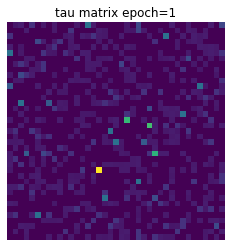

In [114]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure("tau matrix") # 图像窗口名称
plt.imshow(tau_matrix[0], cmap='viridis')
plt.axis('off') # 关掉坐标轴为 off
plt.title('tau matrix epoch=1') # 图像题目
plt.show()

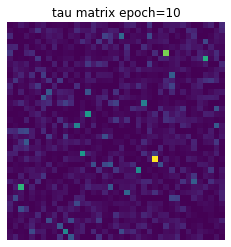

In [115]:
plt.figure("tau matrix") # 图像窗口名称
plt.imshow(tau_matrix[9])
plt.axis('off') # 关掉坐标轴为 off
plt.title('tau matrix epoch=10') # 图像题目
plt.show()

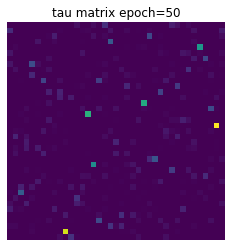

In [116]:
plt.figure("tau matrix") # 图像窗口名称
plt.imshow(tau_matrix[49])
plt.axis('off') # 关掉坐标轴为 off
plt.title('tau matrix epoch=50') # 图像题目
plt.show()

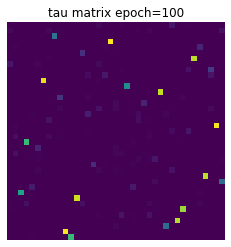

In [118]:
plt.figure("tau matrix") # 图像窗口名称
plt.imshow(tau_matrix[99])
plt.axis('off') # 关掉坐标轴为 off
plt.title('tau matrix epoch=100') # 图像题目
plt.show()



In [141]:
mc2_path = path_matrix
mc2_acc = acc_list
mc2_score = score_list
mc2_feats = nf_matrix

In [122]:
pc4_path = path_matrix
pc4_acc = acc_list
pc4_score = score_list

In [127]:
mw1_path = path_matrix
mw1_acc = acc_list
mw1_score = score_list

In [128]:
len(mw1_acc)

100

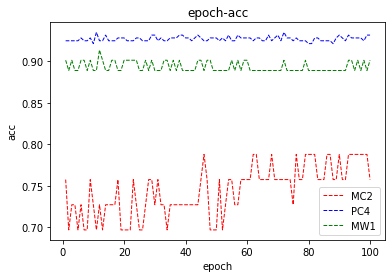

In [131]:
plt.figure()
x = list(range(1, 101))
plt.title("epoch-acc")
plt.plot(x, mc2_acc, color='red', linewidth=1.0, linestyle='--', label='MC2')
plt.plot(x, pc4_acc, color='blue', linewidth=1.0, linestyle='--', label='PC4')
plt.plot(x, mw1_acc, color='green', linewidth=1.0, linestyle='--', label='MW1')
plt.legend(loc='best')
plt.xlabel('epoch', fontdict={'size': 10, 'color': 'black'})
plt.ylabel('acc', fontdict={'size': 10, 'color': 'black'})
plt.show()

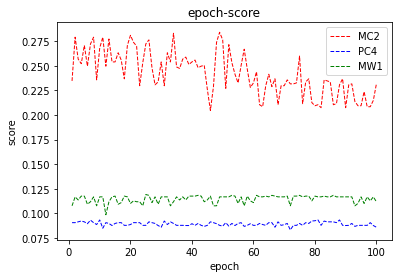

In [132]:
plt.figure()
x = list(range(1, 101))
plt.title("epoch-score")
plt.plot(x, mc2_score, color='red', linewidth=1.0, linestyle='--', label='MC2')
plt.plot(x, pc4_score, color='blue', linewidth=1.0, linestyle='--', label='PC4')
plt.plot(x, mw1_score, color='green', linewidth=1.0, linestyle='--', label='MW1')
plt.legend(loc='best')
plt.xlabel('epoch', fontdict={'size': 10, 'color': 'black'})
plt.ylabel('score', fontdict={'size': 10, 'color': 'black'})
plt.show()

In [48]:
n_epochs = 100
n_dims = train_data.shape[1]
n_ants = 5
print("the Num of the total features:", n_dims)

alpha = 1
beta = 0.2
omega = 0.8
rho = 0.3
mu = 0.7
gamma = 0.8

tau = np.ones([n_dims, n_dims]) # tau 即信息素矩阵
eta = init_eta(train_data, train_label, test_data, test_label) # eta 即启发式信息
print("init finishing")
feat_list = list(range(n_dims)) # feature 总list
best_score = np.inf
score_list = []
acc_list = []

# p_matrix = np.zeros((n_epochs, n_dims, n_dims))
path_matrix = np.zeros((n_epochs, n_ants, n_dims))
nf_matrix = np.zeros((n_epochs, n_ants))
tau_matrix = np.zeros((n_epochs, n_dims, n_dims))

for epoch in range(n_epochs):

    # ============ apply once fs ============
    ant_path = np.zeros([n_ants, n_dims])           # 初始化每只蚂蚁在当前迭代中的路径, 88 means NULL
    ant_acc = np.zeros(n_ants)
    ant_score = np.zeros(n_ants)
    n_feats = np.random.randint(1, n_dims, size=n_ants) # 初始化每只蚂蚁需要选择的特征数

    for i in range(n_ants):

        ant_path[i, 0] = np.random.randint(n_dims)  # 为每只蚂蚁选择起始节点（特征）
        # ant_path[i, 0] = i
        visited = []                                # 已选择的 feature list
        
        for d in range(n_feats[i]-1):               # 共选择 n_feats-1 次特征
            visited.append(ant_path[i, d])          # 更新 selected 表
            # eta = update_eta(train_data, train_label, test_data, test_label, visited)
                                                    # 更新启发式信息, eta = TPR / d, array(n_dims,)
            p = (tau[int(visited[-1])] ** alpha) * (eta[int(visited[-1])] ** beta)
            p[[int(i) for i in visited]] = 0
            prob = p / sum(p)                       # 计算路径转移矩阵
            route = select_route(prob)              # 寻找下一个特征
            ant_path[i, d+1] = route

    path_matrix[epoch] = ant_path
    nf_matrix[epoch] = n_feats

    # ==== evaluate each selected subset ====
    for j in range(n_ants):
        selected = list(ant_path[j, :n_feats[j]])
        f, acc = fitness_func(train_data, train_label, test_data, test_label, selected, omega)
                                                    # 计算适应度函数
        ant_score[j] = f
        ant_acc[j] = acc
        if f <= best_score:                          # 保存为全局的最优解
            best_path = ant_path[j]
            best_score = f
            best_path_acc = acc
    
    best_ant = np.argmin(ant_score)                 # 最优蚂蚁
    near_ant = np.argmin(np.concatenate([ant_score[:best_ant], [0], ant_score[best_ant+1:]]))
                                                    # 第二优蚂蚁
    print("Epoch {} Best Score: {}, the Accuracy: {}, Num of Features: {}".format(\
        epoch, ant_score[best_ant], ant_acc[best_ant], n_feats[best_ant]))
    
    score_list.append(ant_score[best_ant])
    acc_list.append(ant_acc[best_ant])

    # ======== update the eta matrix ========
    
    # stage 1 updating
    deta_tau_k = np.zeros([n_ants, n_dims, n_dims])
    for k in range(n_ants):
        value = mu * ant_acc[k] + (1-mu) / n_feats[k] # 更新值
        for m in range(n_feats[k]-1):
            a, b = int(ant_path[k, m]), int(ant_path[k, m+1])
            deta_tau_k[int(k), a, b] = value

    deta_tau_1 = np.sum(deta_tau_k, 0)
    
    # update
    tau = (1-rho) * tau + rho * deta_tau_1
    tau_matrix[epoch] = tau

print("The Best Ant Path: ", best_path)
print("The Best Score: ", best_score)
print("The Accuracy use Best Path: ", best_path_acc)



  3%|▎         | 1/37 [00:00<00:05,  6.15it/s]

the Num of the total features: 37


100%|██████████| 37/37 [00:07<00:00,  5.23it/s]
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


init finishing
Epoch 0 Best Score: 0.09770620829056637, the Accuracy: 0.9135802469135802, Num of Features: 2
Epoch 1 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4
Epoch 2 Best Score: 0.0937800098556649, the Accuracy: 0.9259259259259259, Num of Features: 9
Epoch 3 Best Score: 0.10865141093643887, the Accuracy: 0.9135802469135802, Num of Features: 14
Epoch 4 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4
Epoch 5 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 6 Best Score: 0.10449243888495878, the Accuracy: 0.9259259259259259, Num of Features: 19
Epoch 7 Best Score: 0.10449243888495878, the Accuracy: 0.9259259259259259, Num of Features: 19
Epoch 8 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4
Epoch 9 Best Score: 0.09569734954187077, the Accuracy: 0.9259259259259259, Num of Features: 11
Epoch 10 Best Score: 0.09929305596873186, 

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 12 Best Score: 0.10011923111304472, the Accuracy: 0.9135802469135802, Num of Features: 5
Epoch 13 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 14 Best Score: 0.09985742033794388, the Accuracy: 0.9259259259259259, Num of Features: 15
Epoch 15 Best Score: 0.10759772466100134, the Accuracy: 0.9135802469135802, Num of Features: 13
Epoch 16 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 17 Best Score: 0.10449243888495878, the Accuracy: 0.9259259259259259, Num of Features: 19
Epoch 18 Best Score: 0.10700476462907696, the Accuracy: 0.9259259259259259, Num of Features: 21
Epoch 19 Best Score: 0.09770620829056637, the Accuracy: 0.9135802469135802, Num of Features: 2

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_l


Epoch 20 Best Score: 0.10211230947211136, the Accuracy: 0.9259259259259259, Num of Features: 17
Epoch 21 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 22 Best Score: 0.09770620829056637, the Accuracy: 0.9135802469135802, Num of Features: 2
Epoch 23 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 24 Best Score: 0.1065721349987784, the Accuracy: 0.9135802469135802, Num of Features: 12
Epoch 25 Best Score: 0.10011923111304472, the Accuracy: 0.9135802469135802, Num of Features: 5


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 26 Best Score: 0.09848891083849282, the Accuracy: 0.9135802469135802, Num of Features: 3
Epoch 27 Best Score: 0.11541040557844992, the Accuracy: 0.9259259259259259, Num of Features: 27
Epoch 28 Best Score: 0.10011923111304472, the Accuracy: 0.9135802469135802, Num of Features: 5
Epoch 29 Best Score: 0.09848891083849282, the Accuracy: 0.9135802469135802, Num of Features: 3
Epoch 30 Best Score: 0.10011923111304472, the Accuracy: 0.9135802469135802, Num of Features: 5
Epoch 31 Best Score: 0.09772118145112474, the Accuracy: 0.9259259259259259, Num of Features: 13
Epoch 32 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 33 Best Score: 0.10836545404836931, the Accuracy: 0.9012345679012346, Num of Features: 3
Epoch 34 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14
Epoch 35 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14
Epoch 36 Best Score: 0.10365655306554147, the Accuracy: 0.9135802469135802, Num of Features: 9
Epoch 37 Best Score: 0.12303937962166012, the Accuracy: 0.9012345679012346, Num of Features: 18
Epoch 38 Best Score: 0.09770620829056637, the Accuracy: 0.9135802469135802, Num of Features: 2
Epoch 39 Best Score: 0.10096963009499182, the Accuracy: 0.9259259259259259, Num of Features: 16
Epoch 40 Best Score: 0.10557389275174736, the Accuracy: 0.9135802469135802, Num of Features: 11

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide



Epoch 41 Best Score: 0.10758275150044286, the Accuracy: 0.9012345679012346, Num of Features: 2
Epoch 42 Best Score: 0.10449243888495878, the Accuracy: 0.9259259259259259, Num of Features: 19
Epoch 43 Best Score: 0.10916959917860836, the Accuracy: 0.9012345679012346, Num of Features: 4
Epoch 44 Best Score: 0.10011923111304472, the Accuracy: 0.9135802469135802, Num of Features: 5
Epoch 45 Best Score: 0.10328629320190705, the Accuracy: 0.9259259259259259, Num of Features: 18
Epoch 46 Best Score: 0.09985742033794388, the Accuracy: 0.9259259259259259, Num of Features: 15


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 47 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 48 Best Score: 0.09569734954187077, the Accuracy: 0.9259259259259259, Num of Features: 11
Epoch 49 Best Score: 0.10682091976697401, the Accuracy: 0.9012345679012346, Num of Features: 1
Epoch 50 Best Score: 0.10682091976697401, the Accuracy: 0.9012345679012346, Num of Features: 1
Epoch 51 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 52 Best Score: 0.09985742033794388, the Accuracy: 0.9259259259259259, Num of Features: 15
Epoch 53 Best Score: 0.11198885268198797, the Accuracy: 0.9135802469135802, Num of Features: 17
Epoch 54 Best Score: 0.09569734954187077, the Accuracy: 0.9259259259259259, Num of Features: 11


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_l

Epoch 55 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4
Epoch 56 Best Score: 0.10682091976697401, the Accuracy: 0.9012345679012346, Num of Features: 1
Epoch 57 Best Score: 0.10365655306554147, the Accuracy: 0.9135802469135802, Num of Features: 9
Epoch 58 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 59 Best Score: 0.09985742033794388, the Accuracy: 0.9259259259259259, Num of Features: 15
Epoch 60 Best Score: 0.10758275150044286, the Accuracy: 0.9012345679012346, Num of Features: 2
Epoch 61 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 62 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 63 Best Score: 0.10011923111304472, the Accuracy: 0.9135802469135802, Num of Features: 5
Epoch 64 Best Score: 0.09985742033794388, the Accuracy: 0.9259259259259259, Num of Features: 15
Epoch 65 Best Score: 0.09669559178890183, the Accuracy: 0.9259259259259259, Num of Features: 12
Epoch 66 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 67 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 68 Best Score: 0.10557389275174736, the Accuracy: 0.9135802469135802, Num of Features: 11
Epoch 69 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide



Epoch 70 Best Score: 0.0937800098556649, the Accuracy: 0.9259259259259259, Num of Features: 9
Epoch 71 Best Score: 0.11084617330486843, the Accuracy: 0.9135802469135802, Num of Features: 16
Epoch 72 Best Score: 0.11541040557844992, the Accuracy: 0.9259259259259259, Num of Features: 27
Epoch 73 Best Score: 0.09877486772656227, the Accuracy: 0.9259259259259259, Num of Features: 14
Epoch 74 Best Score: 0.10557389275174736, the Accuracy: 0.9135802469135802, Num of Features: 11
Epoch 75 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_l

Epoch 76 Best Score: 0.10460226869929956, the Accuracy: 0.9135802469135802, Num of Features: 10
Epoch 77 Best Score: 0.1065721349987784, the Accuracy: 0.9135802469135802, Num of Features: 12
Epoch 78 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 79 Best Score: 0.10682091976697401, the Accuracy: 0.9012345679012346, Num of Features: 1
Epoch 80 Best Score: 0.10449243888495878, the Accuracy: 0.9259259259259259, Num of Features: 19
Epoch 81 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 82 Best Score: 0.10365655306554147, the Accuracy: 0.9135802469135802, Num of Features: 9


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 83 Best Score: 0.11198885268198797, the Accuracy: 0.9135802469135802, Num of Features: 17
Epoch 84 Best Score: 0.1027360550008, the Accuracy: 0.9135802469135802, Num of Features: 8
Epoch 85 Best Score: 0.10965662910774328, the Accuracy: 0.9259259259259259, Num of Features: 23
Epoch 86 Best Score: 0.09848891083849282, the Accuracy: 0.9135802469135802, Num of Features: 3
Epoch 87 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 88 Best Score: 0.08782966508068978, the Accuracy: 0.9259259259259259, Num of Features: 2


D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


Epoch 89 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 90 Best Score: 0.09669559178890183, the Accuracy: 0.9259259259259259, Num of Features: 12
Epoch 91 Best Score: 0.10831277995579523, the Accuracy: 0.9259259259259259, Num of Features: 22
Epoch 92 Best Score: 0.11198885268198797, the Accuracy: 0.9135802469135802, Num of Features: 17
Epoch 93 Best Score: 0.09024268790316814, the Accuracy: 0.9259259259259259, Num of Features: 5
Epoch 94 Best Score: 0.1065721349987784, the Accuracy: 0.9135802469135802, Num of Features: 12
Epoch 95 Best Score: 0.09929305596873186, the Accuracy: 0.9135802469135802, Num of Features: 4
Epoch 96 Best Score: 0.10184010207695361, the Accuracy: 0.9135802469135802, Num of Features: 7
Epoch 97 Best Score: 0.10096803979622046, the Accuracy: 0.9135802469135802, Num of Features: 6
Epoch 98 Best Score: 0.10096963009499182, the Accuracy: 0.9259259259259259, Num of Features: 16
Epoch 99 Best Score: 0.10836545404836931, the 

D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
D:\Software\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [109]:
tau_matrix = (tau_matrix - np.max(tau_matrix)) / (np.max(tau_matrix) - np.min(tau_matrix))

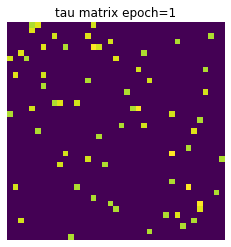

In [110]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure("tau matrix") # 图像窗口名称
plt.imshow(tau_matrix[0], cmap='viridis')
plt.axis('off') # 关掉坐标轴为 off
plt.title('tau matrix epoch=1') # 图像题目
plt.show()

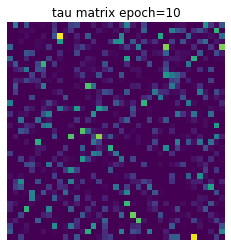

In [111]:
plt.figure("tau matrix") # 图像窗口名称
plt.imshow(tau_matrix[10], cmap='viridis')
plt.axis('off') # 关掉坐标轴为 off
plt.title('tau matrix epoch=10') # 图像题目
plt.show()